# 자동차 연비 예측하기(회귀) with Auto-MPG

회귀(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적이다.</br>
이와 달리 분류(classification)는 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적이다.

이 예제는 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg)데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만든다.<br/>
이 기간에 출시한 자동차 정보를 모델에 제공 할 것이다.<br/>
이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함된다.

## 0. 라이브러리 불러오기

In [2]:
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import seaborn as sns

print(tf.__version__)

2.3.0


In [3]:
pd.set_option('mode.chained_assignment',  None)

## 1. Auto MPG 데이터셋

이 데이터셋은 [UCI 머신러닝 저장소](https://archive.ics.uci.edu/ml/)에서 다운로드 할 수 있다.

### 1-1 데이터 구하기

먼저 데이터셋을 다운로드 해보자.

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/ksc/.keras/datasets/auto-mpg.data'

pandas를 사용하여 데이터를 읽는다.

In [5]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()

dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### 1-2 데이터 정제하기

이 데이터셋은 일부가 누락되어있다.

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

문제를 간단하게 만들기 위해 누락된 행을 제거해보자.

In [7]:
dataset = dataset.dropna()

```origin``` 열은 수치형이 아니고 범주형이므로 원-핫 인코딩으로 변환해보자.

In [8]:
origin = dataset.pop('Origin')

In [9]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


### 1-3 데이터셋을 훈련 세트와 테스트 세트로 분할하기

이제 데이터셋을 훈련 세트와 테스트 세트로 분할해보자.<br/>
테스트세트는 모델을 최종적으로 평가할 때 사용한다.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 1-4 데이터 조사하기

훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 만들어 살펴보자.

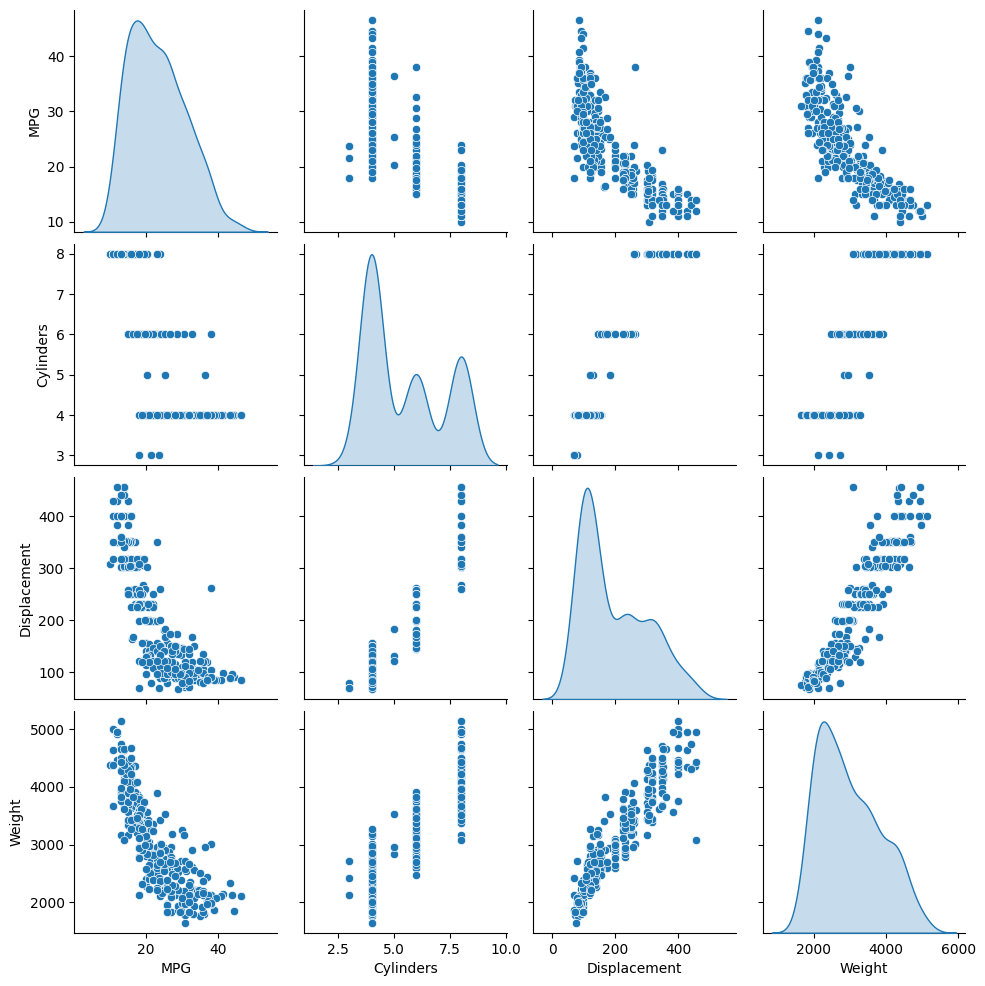

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

전반적인 통계도 살펴보자.

In [12]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 1-5 특성과 레이블 분리하기

특성에서 타깃값 또는 '레이블'을 분리한다.<br/>
이 레이블을 예측하기 위해 모델을 훈련시킬 것이다.

In [13]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 1-6 데이터 정규화

위의 ```train_stats``` 통계를 살펴보고 각 특성의 범위가 얼마나 다른지 확인해보자.

특성의 스케일과 범위가 다르면 정규화(Normalization)를 하는것이 권장된다.<br/>
특성을 정규화하지 않아도 모델이 수렴할 수 있지만, 훈련시키기가 어렵고 입력 단위에 의존적인 모델이 만들어진다.

<span style='background-color:#ffdce0'><노트></span><br/>
의도적으로 훈련 세트만 사용하여 통계치를 생성했다. 이 통계는 테스트 데이터를 정규화 할 때에도 사용된다.<br/>
이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서이다.

In [14]:
def normalization(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = normalization(train_dataset)
normed_test_data = normalization(test_dataset)

정규화된 데이터를 사용하여 모델을 훈련한다.

<span style='background-color:#ffdce0'><주의></span> <br/>
여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 <span style='background-color:#fff5b1'>모든 데이터에 적용되어야 한다.</span><br/>
여기에서 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함된다.

## 2. 모델

### 2-1 모델 만들기

모델을 구성해보자.<br/>
여기에서는 두 개의 완전연결 은닉층으로 ```Sequential```모델을 만들어보자.<br/>
출력층은 하나의 연속적인 값을 반환한다. 나중에 두 번째 모델을 만들기 쉽도록 ```build_model```함수로 모델 구성 단계를 감쌀 것이다.

In [15]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

In [16]:
model = build_model()

### 2-2 모델 확인

```.summary``` 메서드를 사용해 모델에 대한 간단한 정보를 출력한다.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


모델을 한번 실행해보자.<br/>
훈련 세트에서 ```10```샘플을 하나의 배치로 만들어 ```model.predict```메서드를 호출해보자.

In [18]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.22768332],
       [-0.35771784],
       [-0.32054526],
       [-0.5333155 ],
       [-0.94694483],
       [-0.38296208],
       [-1.083161  ],
       [-0.27540654],
       [-0.27826884],
       [-0.9565793 ]], dtype=float32)

### 2-3 모델 훈련

이 모델을 1,000번의 에포크(epoch)동안 훈련한다. 훈련 정확도와 검증 정확도는 ```history``` 객체에 기록된다.

In [19]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('.')

Epochs = 1000

history = model.fit(normed_train_data, train_labels,
                    epochs=Epochs,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[PrintDot()])

.
.
.
.
.
.
.
.
.
.


```history``` 객체에 저장된 통계치를 사용해 모델 훈련 과정을 시각화해보자.

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,585.568420,22.907003,585.568420,575.257568,22.611021,575.257568,0
1,536.605225,21.761179,536.605225,531.090210,21.555086,531.090210,1
2,494.397827,20.744223,494.397827,483.974823,20.399349,483.974823,2
3,449.315063,19.612610,449.315063,432.993103,19.104528,432.993103,3
4,400.303101,18.331276,400.303101,378.078186,17.638660,378.078186,4
...,...,...,...,...,...,...,...
995,2.614629,0.994933,2.614629,7.998733,2.144089,7.998733,995
996,2.857250,1.015415,2.857250,8.106292,2.132083,8.106292,996
997,2.694344,1.012198,2.694344,8.023430,2.125127,8.023430,997
998,2.559630,0.964843,2.559630,8.637166,2.198970,8.637166,998


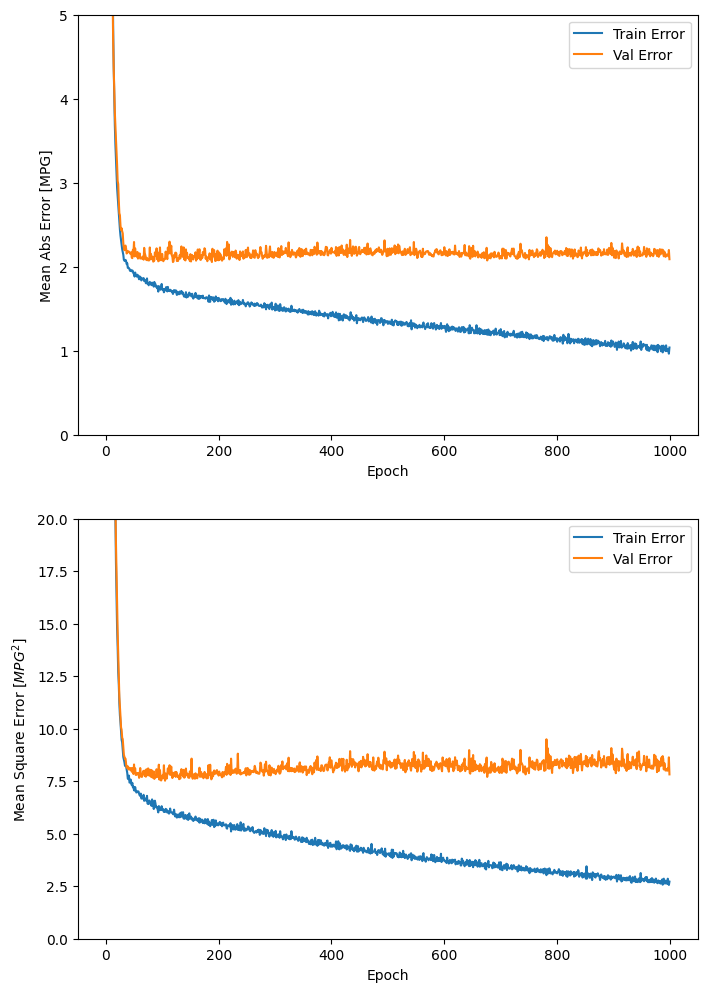

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

이 그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것 같다.<br/>
```model.fit``` 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어보자.<br/>
에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백을 사용해보자.<br/>
지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춘다.<br/>
이 콜백에 대해 더 자세한 내용은 [여기](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=ko)를 참고해보자.

.


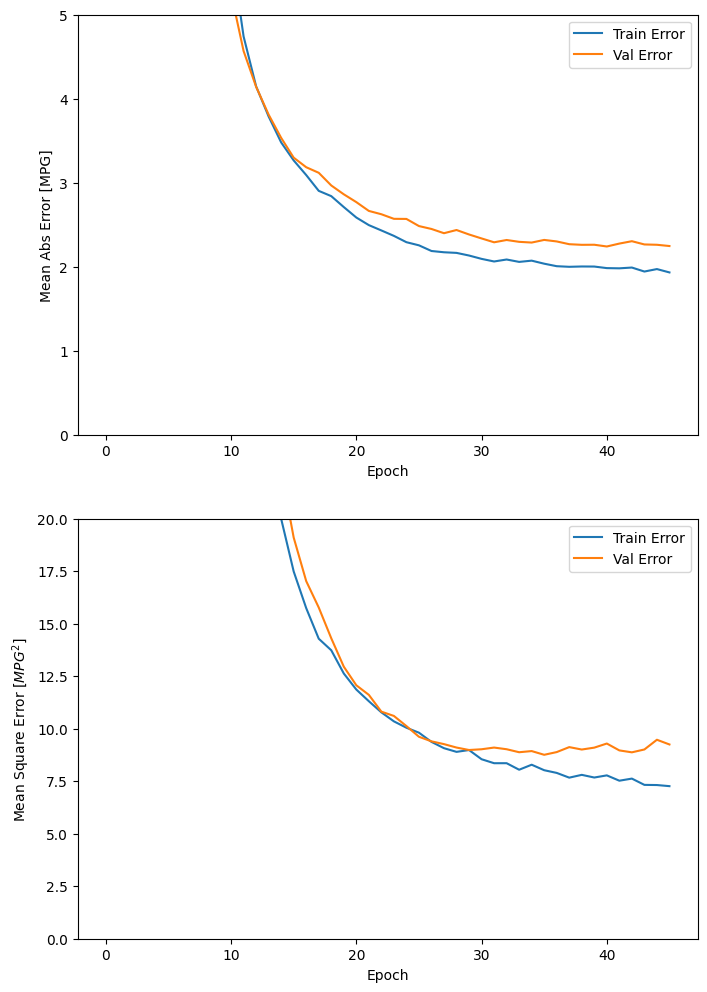

In [22]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels,
                    epochs=Epochs,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

다음으로 테스트 세트에서 모델의 성능을 확인해보자.<br/>

In [23]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print('테스트 세트의 평균 절대 오차 : {:5.2f} MPG'.format(mae))

3/3 - 0s - loss: 6.3285 - mae: 1.9515 - mse: 6.3285
테스트 세트의 평균 절대 오차 :  1.95 MPG


## 3. 예측

마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해보자.

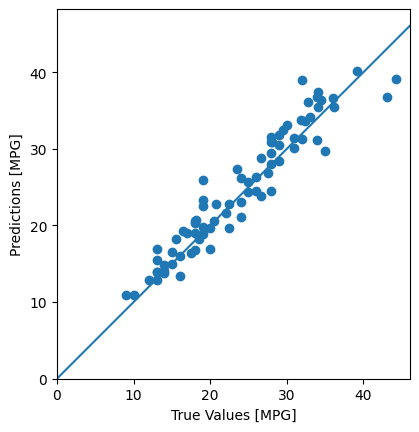

In [24]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

모델이 꽤 잘 예측한 것 같다. 오차의 분포를 살펴보자.

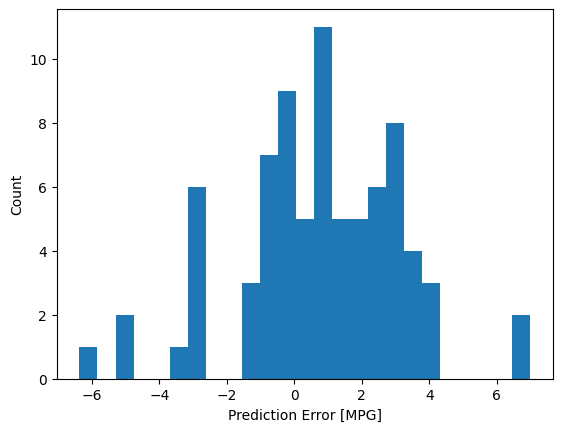

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

훈련 샘플수가 적기 때문에 가우시간 분포는 아니다.

## 4. 결론

이 노트북은 회귀 문제를 위한 기법을 소개한다.<br/>
* <span style='background-color:#fff5b1'>MSE</span>(Mean Square Error : 평균 제곱 오차)는 <span style='background-color:#fff5b1'>회귀 문제에서 자주 사용하는 손실 함수이다.(분류 문제에서 사용하는 손실함수와는 다르다)</span>
* 비슷하게 회귀에도 사용되는 평가 지표도 분류와 다르다. <span style='background-color:#fff5b1'>많이 사용하는 지표는 MAE(Mean Absolute Error : 평균 절대 오차)이다.</span>
* 수치 입력 데이터의 특성이 여러가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 <span style='background-color:#fff5b1'>독립적으로 조정</span>해야 한다.
* 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 <span style='background-color:#fff5b1'>소규모 네트워크</span>를 선택하는 방법이 좋다.
* <span style='background-color:#fff5b1'>조기 종료(Early Stopping)</span>은 과대적합을 방지하기 위한 좋은 방법이다.